In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json

Brief intro into the bpps files (base pairing probability matrix of every possible base pair). These are 107 X 107 symmetric matrices, 107 is the number of bases in a RNA sequence

Ingesting the test dataset which is in json format, then bringing it in pandas dataframe

In [2]:
pd.set_option('display.max_colwidth', None)
json_data = [json.loads(line) for line in open('/kaggle/input/stanford-covid-vaccine/test.json', 'r')]
test_df = pd.DataFrame(json_data)
print(test_df.shape)
#test_df.head(2).T

(3634, 7)


Ingesting the training dataset which is in json format, then bringing it in pandas dataframe

In [3]:
pd.set_option('display.max_colwidth', None)
json_data = [json.loads(line) for line in open('/kaggle/input/stanford-covid-vaccine/train.json', 'r')]
train_df = pd.DataFrame(json_data)
print(train_df.shape)
#train_df.head(2).T

(2400, 19)


In [4]:
train_df.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')

In [5]:
train_df[['id','sequence','structure']].head(10)

,id,sequence,structure
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC,.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACCGCGCGCGCUUAUGCAAGUUGCCCGCGGCGUUCGCGCUGUGAAAAGAAACAACAACAACAAC,.....(((((((((((((((((((((((....)))))))))).)))))))))))))..(((...))).(((((((....))))))).....................
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAUCGAAAUAGCAUCGAUGUGUAUAUGGGUGGUUCGCCGCUCAAAAAGAAACAACAACAACAAC,.....((((.((.....((((.(((.....)))..((((......))))..)))).....)).)))).(((((((....))))))).....................
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGCGCGCGCGCCCUAGUCGUGGUGCUCGAGGUUUCGACCUCGAAAAAGAAACAACAACAACAAC,......((((((((((((((((......))))))))))))))))((((.(((((....).))))))))(((((((....))))))).....................
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUAUAUUAUAUAAAUAUAUAUAUAUAAAAUAUUUCGAUAUUUUAAAAGAAACAACAACAACAAC,.....(((((((.((((((((((((.(((((((((....))))))))))))))).)))))))))))))(((((((....))))))).....................
5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCACAGCGCCGCAGCGGCACACACACCGUAAGUUCGCUUGCGGAAAAGAAACAACAACAACAAC,.....(.(((((.(((((((((...........)))))))..(((.....))))).))))).).....(((((((....))))))).....................
6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGGAGUCGGAAGUCGAUGCAACAAAGCAAAGCUUCGGCUUUGCAAAAGAAACAACAACAACAAC,.........((((((((......((((((((((((....)))))))))))).....))))))))....(((((((....))))))).....................
7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGAACGGACACAAGUCCUCGAUGAACGAAUGCUUCGGCGUUCGAAAAGAAACAACAACAACAAC,.....(((((((((((..(((((((((..((((....))))..)))))))))....))))))))))).(((((((....))))))).....................
8,id_00fcc5cd1,GGAAAGCCAUACCUAGGCGCAAGCCUAGGUAUGGCGGUGAUCUGGUAGCGCAAGCUACCAGAUCACCAGCGAAGCUUCGGCUUCGCAAAAGAAACAACAACAACAAC,.....(((((((((((((....)))))))))))))((((((((((((((....)))))))))))))).(((((((....))))))).....................
9,id_010ab0472,GGAAAGCAUGGGACCACGAUUCACAUCGGUCUGCACGUAGGACAUUCUUGUAGUUAGGUUCUACGUCAAUGGGAGUUCGCUUCUAUAAAAGAAACAACAACAACAAC,.....(((...((((..(((....))))))))))(((((((((...((...))....)))))))))..(((((((....))))))).....................


Bringing the bpps data of every sample

Vectorized method, without creating another dataframe, thereby saving memory

In [6]:
def get_bpps(row):
    file_location = "".join(['/kaggle/input/stanford-covid-vaccine/bpps/',row['id'],'.npy'])
    bpps_data = np.load(file_location)
    bpps_data_list = list(bpps_data)
    bpps_data_list_68 = bpps_data_list[0:68]
    bpps_data_list_68_68 = []
    for j in range(len(bpps_data_list_68)):
        bpps_data_list_68_68.append(bpps_data_list_68[j][0:68])
        
    row['bpps'] = bpps_data_list_68_68
    return row['bpps']

train_df['bpps'] = train_df.apply(get_bpps, axis=1)

## Verifications
print(train_df.shape)
"""print(len(train_df['sequence'][100]))
print(len(train_df['deg_50C']))
print(len(train_df['deg_error_50C'][4]))
print(len(train_df['bpps']))
print(len(train_df['bpps'][2399]))
print(len(train_df['bpps'][2399][60]))
print(len(train_df['deg_error_Mg_50C'][1]))
print((train_df['reactivity'][1]))
print((train_df['sequence'][1]))
print((train_df['structure'][1]))"""

(2400, 20)


"print(len(train_df['sequence'][100]))\nprint(len(train_df['deg_50C']))\nprint(len(train_df['deg_error_50C'][4]))\nprint(len(train_df['bpps']))\nprint(len(train_df['bpps'][2399]))\nprint(len(train_df['bpps'][2399][60]))\nprint(len(train_df['deg_error_Mg_50C'][1]))\nprint((train_df['reactivity'][1]))\nprint((train_df['sequence'][1]))\nprint((train_df['structure'][1]))"

List based approach, takes way much shorter time than the brute force method

In [7]:
colms = ['id_base', 'sequence', 'structure', 'predicted_loop_type', 'signal_to_noise', 'SN_filter', 'reactivity_error'
         , 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'bpps']

def create_rows_per_base(col_name):
    col_list = []
    for i in range(train_df.shape[0]):
        if col_name == 'id_base':
            s = train_df['id'][i]
            for j in range(68):
                col_list.append("_".join([s, str(j)]))
        else:
            for j in range(68):
                if (col_name == 'signal_to_noise') or (col_name == 'SN_filter'):
                    col_list.append(train_df[col_name][i])
                else:
                    col_list.append(train_df[col_name][i][j])
            
    return col_list

d = {}
for colum in colms:
    d[colum] = create_rows_per_base(colum)

seqn_train_df = pd.DataFrame(d, columns=colms)
seqn_train_df['paired_or_unpaired'] = seqn_train_df['structure'].apply(lambda x: 1 if x == '(' else 1 if x == ')' else 0)

Creating 68 BPPS columns per base

In [8]:
def add_bpps_per_base(s,j):
    return s[j]

vect_func = np.vectorize(add_bpps_per_base, excluded=['j'])

for jj in range(68):
    seqn_train_df["_".join(['bpps',str(jj)])] = vect_func(seqn_train_df['bpps'], jj)
    
print(seqn_train_df.shape)

(163200, 86)


Squaring the numeric columns to avoid the negatives and bring everything onto a similar 2D scale

In [9]:
seqn_train_df_sqrd = seqn_train_df.drop(['structure','signal_to_noise','SN_filter','bpps'],axis=1)

colms_to_sqr = ['reactivity_error','deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C','deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'
                , 'bpps_0', 'bpps_1', 'bpps_2', 'bpps_3', 'bpps_4', 'bpps_5', 'bpps_6', 'bpps_7', 'bpps_8', 'bpps_9', 'bpps_10',
       'bpps_11', 'bpps_12', 'bpps_13', 'bpps_14', 'bpps_15', 'bpps_16','bpps_17', 'bpps_18', 'bpps_19', 'bpps_20', 'bpps_21', 'bpps_22',
       'bpps_23', 'bpps_24', 'bpps_25', 'bpps_26', 'bpps_27', 'bpps_28','bpps_29', 'bpps_30', 'bpps_31', 'bpps_32', 'bpps_33', 'bpps_34',
       'bpps_35', 'bpps_36', 'bpps_37', 'bpps_38', 'bpps_39', 'bpps_40','bpps_41', 'bpps_42', 'bpps_43', 'bpps_44', 'bpps_45', 'bpps_46',
       'bpps_47', 'bpps_48', 'bpps_49', 'bpps_50', 'bpps_51', 'bpps_52','bpps_53', 'bpps_54', 'bpps_55', 'bpps_56', 'bpps_57', 'bpps_58',
       'bpps_59', 'bpps_60', 'bpps_61', 'bpps_62', 'bpps_63', 'bpps_64','bpps_65', 'bpps_66', 'bpps_67']

for i in range(len(colms_to_sqr)):
    col_name = colms_to_sqr[i]
    sqrd_col_name = "_".join([col_name,'sqrd'])
    seqn_train_df_sqrd[sqrd_col_name] = np.square(seqn_train_df_sqrd[col_name])
    
seqn_train_df_sqrd.drop(colms_to_sqr, axis=1, inplace=True)
    
seqn_train_df_sqrd.shape

(163200, 82)

In [10]:
seqn_train_df_sqrd.columns

Index(['id_base', 'sequence', 'predicted_loop_type', 'paired_or_unpaired',
       'reactivity_error_sqrd', 'deg_error_Mg_pH10_sqrd',
       'deg_error_pH10_sqrd', 'deg_error_Mg_50C_sqrd', 'deg_error_50C_sqrd',
       'reactivity_sqrd', 'deg_Mg_pH10_sqrd', 'deg_pH10_sqrd',
       'deg_Mg_50C_sqrd', 'deg_50C_sqrd', 'bpps_0_sqrd', 'bpps_1_sqrd',
       'bpps_2_sqrd', 'bpps_3_sqrd', 'bpps_4_sqrd', 'bpps_5_sqrd',
       'bpps_6_sqrd', 'bpps_7_sqrd', 'bpps_8_sqrd', 'bpps_9_sqrd',
       'bpps_10_sqrd', 'bpps_11_sqrd', 'bpps_12_sqrd', 'bpps_13_sqrd',
       'bpps_14_sqrd', 'bpps_15_sqrd', 'bpps_16_sqrd', 'bpps_17_sqrd',
       'bpps_18_sqrd', 'bpps_19_sqrd', 'bpps_20_sqrd', 'bpps_21_sqrd',
       'bpps_22_sqrd', 'bpps_23_sqrd', 'bpps_24_sqrd', 'bpps_25_sqrd',
       'bpps_26_sqrd', 'bpps_27_sqrd', 'bpps_28_sqrd', 'bpps_29_sqrd',
       'bpps_30_sqrd', 'bpps_31_sqrd', 'bpps_32_sqrd', 'bpps_33_sqrd',
       'bpps_34_sqrd', 'bpps_35_sqrd', 'bpps_36_sqrd', 'bpps_37_sqrd',
       'bpps_38_sqrd', '

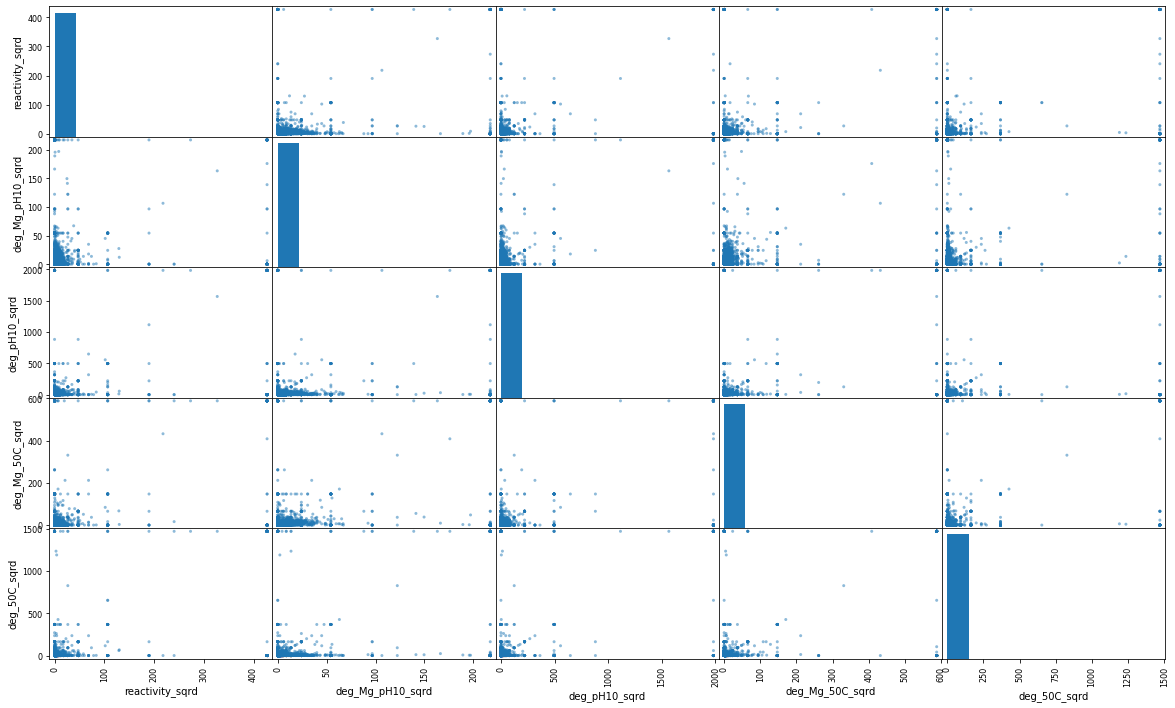

In [11]:
from pandas.plotting import scatter_matrix

attributes = ['reactivity_sqrd', 'deg_Mg_pH10_sqrd', 'deg_pH10_sqrd', 'deg_Mg_50C_sqrd', 'deg_50C_sqrd']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

<AxesSubplot:xlabel='deg_pH10_sqrd', ylabel='deg_Mg_pH10_sqrd'>

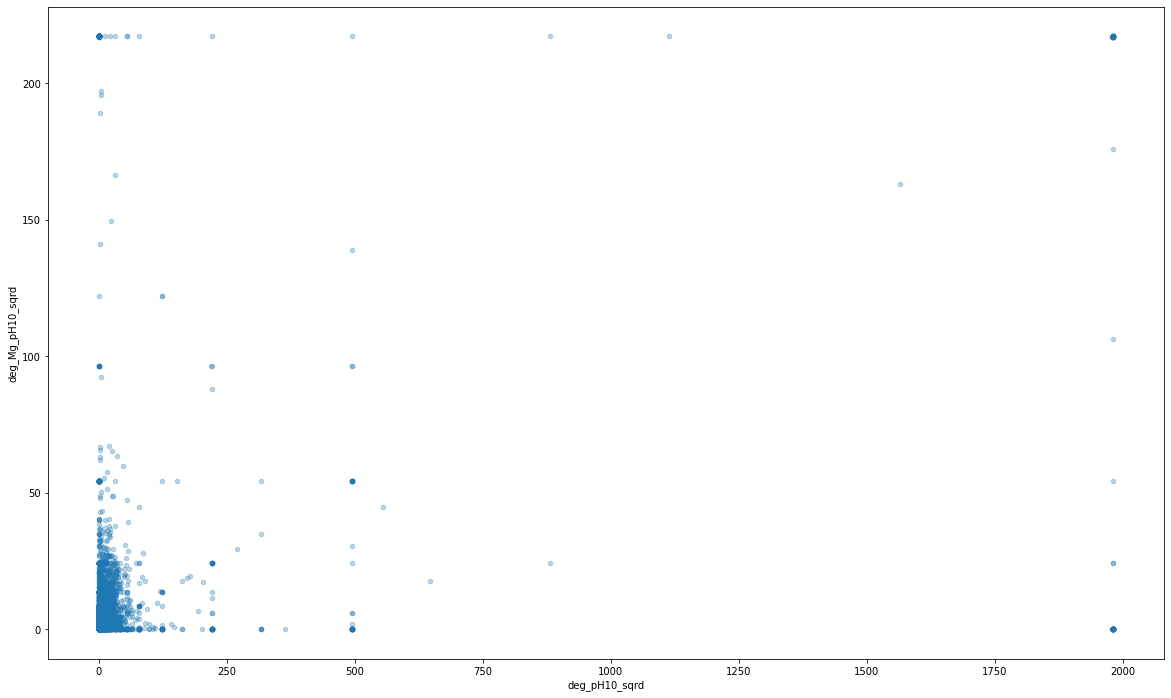

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

seqn_train_df_sqrd.plot(kind="scatter", x="deg_pH10_sqrd", y="deg_Mg_pH10_sqrd", alpha=0.3, figsize=(20,12))

Observing a polynomial relationship which has quite a few outliers, applying standardization (subtract by mean then divide by standard deviation) to reduce those.
Using standardization to reduce the effect of outliers in feature scaling

In [13]:
colms_for_std = ['reactivity_error_sqrd', 'deg_error_Mg_pH10_sqrd',
       'deg_error_pH10_sqrd', 'deg_error_Mg_50C_sqrd', 'deg_error_50C_sqrd',
       'reactivity_sqrd', 'deg_Mg_pH10_sqrd', 'deg_pH10_sqrd',
       'deg_Mg_50C_sqrd', 'deg_50C_sqrd', 'bpps_0_sqrd', 'bpps_1_sqrd',
       'bpps_2_sqrd', 'bpps_3_sqrd', 'bpps_4_sqrd', 'bpps_5_sqrd',
       'bpps_6_sqrd', 'bpps_7_sqrd', 'bpps_8_sqrd', 'bpps_9_sqrd',
       'bpps_10_sqrd', 'bpps_11_sqrd', 'bpps_12_sqrd', 'bpps_13_sqrd',
       'bpps_14_sqrd', 'bpps_15_sqrd', 'bpps_16_sqrd', 'bpps_17_sqrd',
       'bpps_18_sqrd', 'bpps_19_sqrd', 'bpps_20_sqrd', 'bpps_21_sqrd',
       'bpps_22_sqrd', 'bpps_23_sqrd', 'bpps_24_sqrd', 'bpps_25_sqrd',
       'bpps_26_sqrd', 'bpps_27_sqrd', 'bpps_28_sqrd', 'bpps_29_sqrd',
       'bpps_30_sqrd', 'bpps_31_sqrd', 'bpps_32_sqrd', 'bpps_33_sqrd',
       'bpps_34_sqrd', 'bpps_35_sqrd', 'bpps_36_sqrd', 'bpps_37_sqrd',
       'bpps_38_sqrd', 'bpps_39_sqrd', 'bpps_40_sqrd', 'bpps_41_sqrd',
       'bpps_42_sqrd', 'bpps_43_sqrd', 'bpps_44_sqrd', 'bpps_45_sqrd',
       'bpps_46_sqrd', 'bpps_47_sqrd', 'bpps_48_sqrd', 'bpps_49_sqrd',
       'bpps_50_sqrd', 'bpps_51_sqrd', 'bpps_52_sqrd', 'bpps_53_sqrd',
       'bpps_54_sqrd', 'bpps_55_sqrd', 'bpps_56_sqrd', 'bpps_57_sqrd',
       'bpps_58_sqrd', 'bpps_59_sqrd', 'bpps_60_sqrd', 'bpps_61_sqrd',
       'bpps_62_sqrd', 'bpps_63_sqrd', 'bpps_64_sqrd', 'bpps_65_sqrd',
       'bpps_66_sqrd', 'bpps_67_sqrd']

for i in range(len(colms_for_std)):
    col_name = colms_for_std[i]
    col_name_std = "_".join([col_name, 'std'])
    seqn_train_df_sqrd[col_name_std] = (seqn_train_df_sqrd[col_name] - seqn_train_df_sqrd[col_name].mean())/seqn_train_df_sqrd[col_name].std()

seqn_train_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
    
seqn_train_df_sqrd.shape

(163200, 82)

In [14]:
seqn_train_df_sqrd.columns

Index(['id_base', 'sequence', 'predicted_loop_type', 'paired_or_unpaired',
       'reactivity_error_sqrd_std', 'deg_error_Mg_pH10_sqrd_std',
       'deg_error_pH10_sqrd_std', 'deg_error_Mg_50C_sqrd_std',
       'deg_error_50C_sqrd_std', 'reactivity_sqrd_std', 'deg_Mg_pH10_sqrd_std',
       'deg_pH10_sqrd_std', 'deg_Mg_50C_sqrd_std', 'deg_50C_sqrd_std',
       'bpps_0_sqrd_std', 'bpps_1_sqrd_std', 'bpps_2_sqrd_std',
       'bpps_3_sqrd_std', 'bpps_4_sqrd_std', 'bpps_5_sqrd_std',
       'bpps_6_sqrd_std', 'bpps_7_sqrd_std', 'bpps_8_sqrd_std',
       'bpps_9_sqrd_std', 'bpps_10_sqrd_std', 'bpps_11_sqrd_std',
       'bpps_12_sqrd_std', 'bpps_13_sqrd_std', 'bpps_14_sqrd_std',
       'bpps_15_sqrd_std', 'bpps_16_sqrd_std', 'bpps_17_sqrd_std',
       'bpps_18_sqrd_std', 'bpps_19_sqrd_std', 'bpps_20_sqrd_std',
       'bpps_21_sqrd_std', 'bpps_22_sqrd_std', 'bpps_23_sqrd_std',
       'bpps_24_sqrd_std', 'bpps_25_sqrd_std', 'bpps_26_sqrd_std',
       'bpps_27_sqrd_std', 'bpps_28_sqrd_std', 'bpps

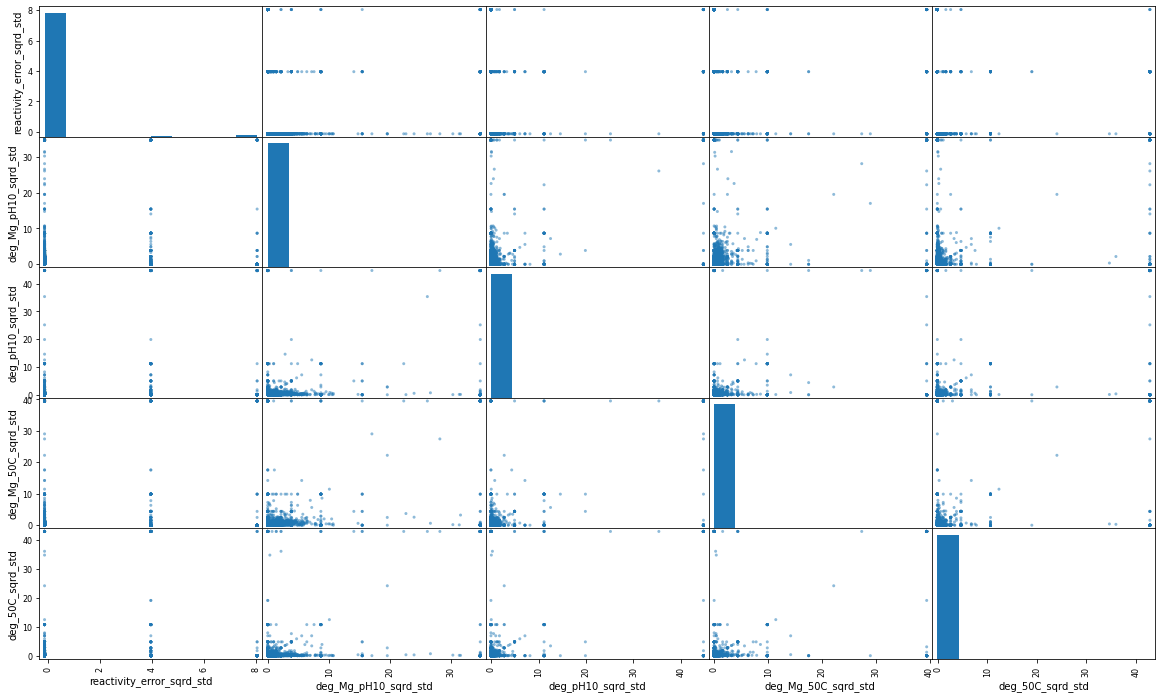

In [15]:
attributes = ['reactivity_error_sqrd_std', 'deg_Mg_pH10_sqrd_std', 'deg_pH10_sqrd_std', 'deg_Mg_50C_sqrd_std', 'deg_50C_sqrd_std']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

In [16]:
from sklearn.preprocessing import OneHotEncoder
loop_type_cat_encoder = OneHotEncoder()

predicted_loop_type_categories = seqn_train_df[['predicted_loop_type']]
predicted_loop_type_cat_1hot = loop_type_cat_encoder.fit_transform(predicted_loop_type_categories)
predicted_loop_type_cat_1hot.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [17]:
loop_type_cat_encoder.categories_

[array(['B', 'E', 'H', 'I', 'M', 'S', 'X'], dtype=object)]